# Balanced Synthetic Data used for training - testing, Real raw and real balanced data used for testing

### import libraries and read data files

In [1]:
from ctgan import CTGAN

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
#define data for each scenarios with data paths
balanced_synthetic_data = pd.read_csv("../Data/balanced_synthetic_data_scenario2.csv")
feature_df = pd.read_csv("../Data/preprocessed_df_scenario2.csv")
balanced_feature_df = pd.read_csv("../Data/balanced_feature_df_scenario2.csv")

# RF

In [ ]:
#import libraries
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import joblib  

#train-test split 7/3
#split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#scale the data (fit on training set and transform both training and test sets)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#RANDOM FOREST

# objective function for Optuna with RandomForestClassifier
def objective(trial):
    #suggest hyperparameters for RandomForestClassifier (range)
    n_estimators = trial.suggest_int("n_estimators", 50, 500)  # Adjust range as needed
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 20)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    bootstrap = trial.suggest_categorical("bootstrap", [True, False])

    # initialize the RandomForestClassifier with the suggested hyperparameters
    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        bootstrap=bootstrap,
        random_state=42,
        n_jobs=-1  # Enable parallel processing
    )

    #use KFold cross-validation (5-fold)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='roc_auc', n_jobs=-1)

    #report the mean ROC-AUC score across all folds
    return roc_aucs.mean()

#set up the Optuna study with pruning enabled, 200 trials (early stop consume more time and gpus)
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=200)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data
best_model = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-27 17:21:35,242] A new study created in memory with name: no-name-900b0481-1ba1-4a3c-a637-ec21b5379fbb
[I 2024-11-27 17:21:48,593] Trial 0 finished with value: 0.8000569359332499 and parameters: {'n_estimators': 133, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 8, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8000569359332499.
[I 2024-11-27 17:22:02,149] Trial 1 finished with value: 0.7855231199528949 and parameters: {'n_estimators': 378, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 20, 'max_features': None, 'bootstrap': False}. Best is trial 0 with value: 0.8000569359332499.
[I 2024-11-27 17:22:16,130] Trial 2 finished with value: 0.8420497235571267 and parameters: {'n_estimators': 365, 'max_depth': 20, 'min_samples_split': 8, 'min_samples_leaf': 17, 'max_features': None, 'bootstrap': True}. Best is trial 2 with value: 0.8420497235571267.
[I 2024-11-27 17:22:24,975] Trial 3 finished with value: 0.849403701847241 and

Best hyperparameters: {'n_estimators': 264, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False}
Best cross-validated ROC-AUC score: 0.8877615633509557
Test ROC-AUC score: 0.8889091629292968
Test Accuracy: 0.8230


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# X and y: synthetic features and labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model = RandomForestClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model.fit(X_train_scaled, y_train)

#TEST ON SYNTHETIC DATA SPLITTED AND SCALED

#evaluate the model on the test data, for each model, change best_model from 1 to 5
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model.predict(X_test_scaled)))

#generate the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_test_scaled))

#extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

#calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

#print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81      2439
           1       0.81      0.86      0.83      2538

    accuracy                           0.82      4977
   macro avg       0.82      0.82      0.82      4977
weighted avg       0.82      0.82      0.82      4977

False Positive Rate (FPR): 0.2161

Confusion Matrix Scores:
True Positives (TP): 2184
True Negatives (TN): 1912
False Positives (FP): 527
False Negatives (FN): 354


In [ ]:
#TEST ON REAL DATASET, for each scenario, change test data file name correspondingly. for each model, change best_model from 1 to 5.

#evaluate the model on the test data
X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label

#scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))
print(classification_report(y_test, best_model.predict(X_real_scaled)))
#generate the confusion matrix
cm = confusion_matrix(y_test, best_model.predict(X_real_scaled))

#extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

#calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

#print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.78      0.67      0.72        48
           1       0.71      0.81      0.76        48

    accuracy                           0.74        96
   macro avg       0.74      0.74      0.74        96
weighted avg       0.74      0.74      0.74        96

False Positive Rate (FPR): 0.3333

Confusion Matrix Scores:
True Positives (TP): 39
True Negatives (TN): 32
False Positives (FP): 16
False Negatives (FN): 9


In [ ]:
import joblib 
joblib.dump(best_model1,"RF_model_case1.pkl")

['RF_model2.pkl']

### XGB

In [3]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np

# Split the data into training and testing sets
X, y = synthetic_data.drop("Label", axis=1), synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Scale the features once for both training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#XGBOOST


#objective function for Optuna with XGBClassifier
def objective(trial):
    #suggest hyperparameters for XGBClassifier
    n_estimators = trial.suggest_int("n_estimators", 20, 300)
    max_depth = trial.suggest_int("max_depth", 3, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)
    gamma = trial.suggest_float("gamma", 0, 5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)

    #initialize the XGBClassifier with the suggested hyperparameters
    model = XGBClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    #set up StratifiedKFold cross-validation (5-fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #cross-validation and calculate ROC-AUC score
    roc_aucs = []
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)
        
        #report intermediate values for pruning with the fold number as the step
        trial.report(np.mean(roc_aucs), fold)
        
        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    #return the mean ROC-AUC across all folds
    return np.mean(roc_aucs)

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=200)  # Adjust n_trials as needed

#print best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model2)
best_model2 = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model2.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model2.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model2.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-29 11:04:40,844] A new study created in memory with name: no-name-fa597e1b-aac5-4e63-8260-d3809788094a
[I 2024-11-29 11:04:41,287] Trial 0 finished with value: 0.5459630859598563 and parameters: {'n_estimators': 137, 'max_depth': 9, 'learning_rate': 0.02737889884951345, 'subsample': 0.924132270937429, 'colsample_bytree': 0.9693131343734434, 'gamma': 3.9093524724951134, 'min_child_weight': 7}. Best is trial 0 with value: 0.5459630859598563.
[I 2024-11-29 11:04:41,975] Trial 1 finished with value: 0.5212405340861647 and parameters: {'n_estimators': 291, 'max_depth': 10, 'learning_rate': 0.24732504206775352, 'subsample': 0.5410047106264154, 'colsample_bytree': 0.6950722727263954, 'gamma': 2.0719187735115465, 'min_child_weight': 8}. Best is trial 0 with value: 0.5459630859598563.
[I 2024-11-29 11:04:42,609] Trial 2 finished with value: 0.5428608191831735 and parameters: {'n_estimators': 237, 'max_depth': 5, 'learning_rate': 0.04300758140981873, 'subsample': 0.5394912528440123, '

Best hyperparameters: {'n_estimators': 85, 'max_depth': 6, 'learning_rate': 0.04974105973401808, 'subsample': 0.710677147966072, 'colsample_bytree': 0.8002264325986135, 'gamma': 4.70986720699052, 'min_child_weight': 10}
Best cross-validated ROC-AUC score: 0.5679063709636174
Test ROC-AUC score: 0.5428334367245657
Test Accuracy: 0.8267


In [4]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model2 = XGBClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model2.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model2.predict(X_test_scaled)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model2.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       520
           1       0.83      1.00      0.91      2480

    accuracy                           0.83      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.68      0.83      0.75      3000

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 2480
True Negatives (TN): 0
False Positives (FP): 520
False Negatives (FN): 0


In [10]:
from sklearn.metrics import classification_report

# Evaluate the model on the test data
X_test, y_test = feature_df.drop("Label", axis=1), feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model2.predict(X_real_scaled)))

# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model2.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        48

    accuracy                           0.80        60
   macro avg       0.40      0.50      0.44        60
weighted avg       0.64      0.80      0.71        60

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 48
True Negatives (TN): 0
False Positives (FP): 12
False Negatives (FN): 0


In [49]:
import joblib 
joblib.dump(best_model2,"XGB_model1.pkl")

['XGB_model1.pkl']

### LOG REG

In [11]:
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X, y = synthetic_data.drop("Label", axis=1), synthetic_data.Label
X_train_scaled, X_test_scaled, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_scaled))
X_test_scaled = pd.DataFrame(scaler.transform(X_test_scaled))


#LOG REG


#objective function for Optuna with Logistic Regression
def objective(trial):
    #suggest hyperparameters for Logistic Regression
    C = trial.suggest_loguniform("C", 1e-4, 1e2)  
    solver = trial.suggest_categorical("solver", ["liblinear", "lbfgs", "saga"]) 
    penalty = trial.suggest_categorical("penalty", ["l1", "l2"]) if solver in ["liblinear", "saga"] else "l2"

    #initialize the Logistic Regression model with suggested hyperparameters
    model = LogisticRegression(
        C=C,
        solver=solver,
        penalty=penalty,
        max_iter=1000,
        random_state=42
    )

    #set up Stratified K-Fold cross-validation (5-fold)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = []

    #cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)

        #report intermediate values for pruning
        intermediate_value = sum(roc_aucs) / len(roc_aucs)
        trial.report(intermediate_value, fold)

        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    #return the mean ROC-AUC across all folds if not pruned
    return sum(roc_aucs) / len(roc_aucs)

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=300)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the scaled test data (best_model3)
best_model3 = LogisticRegression(**best_params, max_iter=1000, random_state=42)
best_model3.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model3.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model3.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")


[I 2024-11-29 11:11:34,824] A new study created in memory with name: no-name-1369a615-f918-456c-8af4-2cd8d3f82536
[I 2024-11-29 11:11:34,972] Trial 0 finished with value: 0.5 and parameters: {'C': 0.004856831254434025, 'solver': 'saga', 'penalty': 'l1'}. Best is trial 0 with value: 0.5.
[I 2024-11-29 11:11:35,066] Trial 1 finished with value: 0.5651272441587954 and parameters: {'C': 0.0001654732011724237, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,116] Trial 2 finished with value: 0.5638644536718107 and parameters: {'C': 0.005244232921880164, 'solver': 'lbfgs'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,181] Trial 3 finished with value: 0.5651151855982572 and parameters: {'C': 0.0006173453057168465, 'solver': 'liblinear', 'penalty': 'l2'}. Best is trial 1 with value: 0.5651272441587954.
[I 2024-11-29 11:11:35,237] Trial 4 finished with value: 0.5634381846047034 and parameters: {'C': 0.0316770602128104, 'solver

Best hyperparameters: {'C': 0.00010241971353372532, 'solver': 'liblinear', 'penalty': 'l2'}
Best cross-validated ROC-AUC score: 0.565739167086993
Test ROC-AUC score: 0.5483157568238213
Test Accuracy: 0.8267


In [12]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# X and y: synthetic features and labels
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the best model with the best hyperparameters found by Optuna
#best_model3 = LogisticRegression(**best_params, random_state=42)

# Fit the best model on the training data
#best_model3.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model3.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model3.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       520
           1       0.83      1.00      0.91      2480

    accuracy                           0.83      3000
   macro avg       0.41      0.50      0.45      3000
weighted avg       0.68      0.83      0.75      3000

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 2480
True Negatives (TN): 0
False Positives (FP): 520
False Negatives (FN): 0


In [13]:
# Evaluate the model on the test data

X_test, y_test = feature_df.drop("Label", axis=1), feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model3.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model3.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        12
           1       0.80      1.00      0.89        48

    accuracy                           0.80        60
   macro avg       0.40      0.50      0.44        60
weighted avg       0.64      0.80      0.71        60

False Positive Rate (FPR): 1.0000

Confusion Matrix Scores:
True Positives (TP): 48
True Negatives (TN): 0
False Positives (FP): 12
False Negatives (FN): 0


In [92]:
import joblib 
joblib.dump(best_model3,"Logreg_model1.pkl")

['Logreg_model1.pkl']

### Dec tree

In [4]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.feature_selection import RFE

# Split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train))
X_test_scaled = pd.DataFrame(scaler.transform(X_test))

# DECISION TREE


#objective function for Optuna with Decision Tree
def objective(trial):
    #suggest hyperparameters for Decision Tree
    max_depth = trial.suggest_int("max_depth", 2, 100)  # Expanded max_depth range
    min_samples_split = trial.suggest_int("min_samples_split", 2, 100)  # Expanded range
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 50)  # Expanded range
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])  # Added "auto" and fraction
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    #initialize the Decision Tree model with suggested hyperparameters
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        criterion=criterion,
        class_weight='balanced',
        random_state=42
    )

    #stratified K-Fold cross-validation (5-fold)
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    roc_aucs = []
    f1_scores = []

    #cross-validation
    for fold, (train_index, val_index) in enumerate(kf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled.iloc[train_index], X_train_scaled.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        #fit the model and calculate ROC-AUC and F1-score for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1] if hasattr(model, "predict_proba") else model.predict(X_fold_val)
        
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        f1 = f1_score(y_fold_val, model.predict(X_fold_val))

        roc_aucs.append(roc_auc)
        f1_scores.append(f1)

    #return the mean ROC-AUC across all folds
    return sum(roc_aucs) / len(roc_aucs)

#set up the Optuna study (no pruning)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=300)  
#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model4)
best_model4 = DecisionTreeClassifier(**best_params, random_state=42)
best_model4.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model4.predict_proba(X_test_scaled)[:, 1] if hasattr(best_model4, "predict_proba") else best_model.predict(X_test_scaled)
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model4.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test F1-Score: {f1:.4f}")


[I 2024-11-28 20:04:08,866] A new study created in memory with name: no-name-f7aea72e-ddc8-454e-a096-25f0412ccca4


[I 2024-11-28 20:04:09,064] Trial 0 finished with value: 0.7354797128143922 and parameters: {'max_depth': 50, 'min_samples_split': 79, 'min_samples_leaf': 40, 'max_features': 'log2', 'criterion': 'gini'}. Best is trial 0 with value: 0.7354797128143922.
[I 2024-11-28 20:04:09,304] Trial 1 finished with value: 0.8256128664388198 and parameters: {'max_depth': 20, 'min_samples_split': 67, 'min_samples_leaf': 33, 'max_features': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8256128664388198.
[I 2024-11-28 20:04:09,408] Trial 2 finished with value: 0.6551653867711161 and parameters: {'max_depth': 3, 'min_samples_split': 58, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'criterion': 'gini'}. Best is trial 1 with value: 0.8256128664388198.
[I 2024-11-28 20:04:09,589] Trial 3 finished with value: 0.82102643884472 and parameters: {'max_depth': 71, 'min_samples_split': 43, 'min_samples_leaf': 30, 'max_features': None, 'criterion': 'gini'}. Best is trial 1 with value: 0.82561286643

Best hyperparameters: {'max_depth': 78, 'min_samples_split': 48, 'min_samples_leaf': 23, 'max_features': None, 'criterion': 'entropy'}
Best cross-validated ROC-AUC score: 0.832740044793864
Test ROC-AUC score: 0.8258500357600654
Test Accuracy: 0.7633
Test F1-Score: 0.7852


In [259]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Initialize the best model with the best hyperparameters found by Optuna
#best_model4 = DecisionTreeClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model4.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model4.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model4.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      2390
           1       0.69      0.73      0.71      2422

    accuracy                           0.70      4812
   macro avg       0.70      0.70      0.70      4812
weighted avg       0.70      0.70      0.70      4812

False Positive Rate (FPR): 0.3423

Confusion Matrix Scores:
True Positives (TP): 1779
True Negatives (TN): 1572
False Positives (FP): 818
False Negatives (FN): 643


In [6]:
from sklearn.metrics import classification_report

X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model4.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model4.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


              precision    recall  f1-score   support

           0       0.88      0.73      0.80        48
           1       0.77      0.90      0.83        48

    accuracy                           0.81        96
   macro avg       0.82      0.81      0.81        96
weighted avg       0.82      0.81      0.81        96



NameError: name 'confusion_matrix' is not defined

In [ ]:
#tree visualisation
dot_data = tree.export_graphviz(best_model4, out_file=None)
graph = graphviz.Source(dot_data) 
graph.render("dec_tree")

In [27]:

import joblib 
joblib.dump(best_model4,"DT_model1.pkl")

              precision    recall  f1-score   support

           0       0.20      0.08      0.12        12
           1       0.80      0.92      0.85        48

    accuracy                           0.75        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.68      0.75      0.71        60



['DT_model1.pkl']

### For READING PKL files

In [46]:
pklread1 = joblib.load("DT_model1.pkl")
y_pred = pklread1.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.20      0.08      0.12        12
           1       0.80      0.92      0.85        48

    accuracy                           0.75        60
   macro avg       0.50      0.50      0.49        60
weighted avg       0.68      0.75      0.71        60



### LightGBM

In [4]:
import optuna
from lightgbm import LGBMClassifier
import logging
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
import numpy as np




# Split the data into training and testing sets
X, y = balanced_synthetic_data.drop("Label", axis=1), balanced_synthetic_data["Label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale the features once for both training and testing sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#LIGHTGBM

#enable logging for better visibility during training
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

#objective function for Optuna with LGBMClassifier
def objective(trial):
    #suggest hyperparameters for LGBMClassifier
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 10, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "min_child_samples": trial.suggest_int("min_child_samples", 10, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
        "random_state": 42,
        "n_jobs": -1,
    }

    #initialize the LGBMClassifier with the suggested hyperparameters
    model = LGBMClassifier(**params)

    #set up StratifiedKFold cross-validation (5-fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    #cross-validation and calculate ROC-AUC score
    roc_aucs = []
    for fold, (train_index, val_index) in enumerate(skf.split(X_train_scaled, y_train)):
        X_fold_train, X_fold_val = X_train_scaled[train_index], X_train_scaled[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        
        #fit the model and calculate ROC-AUC for each fold
        model.fit(X_fold_train, y_fold_train)
        y_pred_proba = model.predict_proba(X_fold_val)[:, 1]
        roc_auc = roc_auc_score(y_fold_val, y_pred_proba)
        roc_aucs.append(roc_auc)
        
        #report intermediate values for pruning with the fold number as the step
        trial.report(np.mean(roc_aucs), step=fold)
        
        #check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # Return the mean ROC-AUC across all folds
    mean_roc_auc = np.mean(roc_aucs)
    logger.info(f"Trial {trial.number}: Mean ROC-AUC = {mean_roc_auc:.4f}")
    return mean_roc_auc

#set up the Optuna study with a pruner
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=2)
study = optuna.create_study(direction="maximize", pruner=pruner)
study.optimize(objective, n_trials=100, show_progress_bar=True)  # Adjust n_trials as needed

#print the best hyperparameters and corresponding ROC-AUC score
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best cross-validated ROC-AUC score:", study.best_value)

#evaluate the best model on the test data (best_model5)
best_model5 = LGBMClassifier(**best_params, random_state=42)
best_model5.fit(X_train_scaled, y_train)
y_test_pred_proba = best_model5.predict_proba(X_test_scaled)[:, 1]
test_roc_auc = roc_auc_score(y_test, y_test_pred_proba)
print("Test ROC-AUC score:", test_roc_auc)

#make predictions on the test set
y_test_pred = best_model5.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Feature Importance Analysis
importances = best_model5.feature_importances_
feature_names = X.columns
feature_importances = sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True)

print("\nFeature Importances:")
for feature, importance in feature_importances:
    print(f"{feature}: {importance}")


[I 2024-11-28 21:17:30,796] A new study created in memory with name: no-name-0124c8ba-f7c2-4435-8f40-9c01d456010e


  0%|          | 0/100 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

INFO:__main__:Trial 0: Mean ROC-AUC = 0.8511


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 1: Mean ROC-AUC = 0.8057


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 2: Mean ROC-AUC = 0.8511


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

INFO:__main__:Trial 3: Mean ROC-AUC = 0.7882


[LightGBM] [Info] Number of positive: 4491, number of negative: 4492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000223
[LightGBM] [Info] Start training from score -0.000223
[I 2024-11-28 21:17:34,363] Trial 3 finished with value: 0.7882436240190401 and parameters: {'num_leaves': 17, 'max_depth': 7, 'learning_rate': 0.02033967874402979, 'n_estimators': 56, 'min_child_samples': 29, 'subsample': 0.83113217609631, 'colsample_bytree': 0.6536669526511817, 'reg_alpha': 0.46056398952296185, 'reg_lambda': 0.8153064700376855}. Best is trial 0 with value: 0.8511315937860047.
[LightGBM] [Info] Number of positive: 4491, numb

INFO:__main__:Trial 4: Mean ROC-AUC = 0.8500


[I 2024-11-28 21:17:35,162] Trial 4 finished with value: 0.8500228088356826 and parameters: {'num_leaves': 138, 'max_depth': 11, 'learning_rate': 0.23095467162027764, 'n_estimators': 101, 'min_child_samples': 11, 'subsample': 0.5071221600522745, 'colsample_bytree': 0.6381147079172558, 'reg_alpha': 1.703512554485983, 'reg_lambda': 3.9571085889808666}. Best is trial 0 with value: 0.8511315937860047.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 5: Mean ROC-AUC = 0.8511


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-11-28 21:17:35,857] Trial 5 finished with value: 0.8510600206770278 and parameters: {'num_leaves': 38, 'max_depth': 15, 'learning_rate': 0.06965801942901678, 'n_estimators': 129, 'min_child_samples': 43, 'subsample': 0.8430893901519142, 'cols

INFO:__main__:Trial 6: Mean ROC-AUC = 0.8516


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 8: Mean ROC-AUC = 0.8515


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 11: Mean ROC-AUC = 0.8525


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 15: Mean ROC-AUC = 0.8512


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -

INFO:__main__:Trial 16: Mean ROC-AUC = 0.8520


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 17: Mean ROC-AUC = 0.8527


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 20: Mean ROC-AUC = 0.8514


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 21: Mean ROC-AUC = 0.8520


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 22: Mean ROC-AUC = 0.8528


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 23: Mean ROC-AUC = 0.8516


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 24: Mean ROC-AUC = 0.8527


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 25: Mean ROC-AUC = 0.8525


[I 2024-11-28 21:17:57,999] Trial 25 finished with value: 0.8525059891409386 and parameters: {'num_leaves': 32, 'max_depth': 14, 'learning_rate': 0.06592045492246267, 'n_estimators': 231, 'min_child_samples': 28, 'subsample': 0.7854481238594997, 'colsample_bytree': 0.9511114082134055, 'reg_alpha': 2.678607200009648, 'reg_lambda': 5.8382746972334525}. Best is trial 22 with value: 0.8528249232962068.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 26: Mean ROC-AUC = 0.8531


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-11-28 21:17:59,704] Trial 26 finished with value: 0.8530927311772445 and parameters: {'num_leaves': 36, 'max_depth': 12, 'learning_rate': 0.04104845788862281, 'n_estimators': 266, 'min_child_samples': 26, 'subsample': 0.7735231909208088, 'colsample_bytree': 0.8519227784755974, 'reg_alpha': 1.0068687685662572, 'reg_lambda': 3.9901731269115146}. Best is trial 26 with value: 0.8530927311772445.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[Li

INFO:__main__:Trial 29: Mean ROC-AUC = 0.8510


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Stopped t

INFO:__main__:Trial 30: Mean ROC-AUC = 0.8531


[I 2024-11-28 21:18:05,088] Trial 30 finished with value: 0.8531248514782899 and parameters: {'num_leaves': 27, 'max_depth': 12, 'learning_rate': 0.03901353447981405, 'n_estimators': 279, 'min_child_samples': 16, 'subsample': 0.6563333856939804, 'colsample_bytree': 0.9397991126853739, 'reg_alpha': 1.2892949072566755, 'reg_lambda': 3.4128780729328048}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosi

INFO:__main__:Trial 35: Mean ROC-AUC = 0.8526


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 38: Mean ROC-AUC = 0.8521


[I 2024-11-28 21:18:15,290] Trial 38 finished with value: 0.8520896790906883 and parameters: {'num_leaves': 43, 'max_depth': 14, 'learning_rate': 0.06200474749036055, 'n_estimators': 283, 'min_child_samples': 30, 'subsample': 0.7068122926586101, 'colsample_bytree': 0.7442612733048136, 'reg_alpha': 5.3888241290441945, 'reg_lambda': 2.8201738396661193}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] 

INFO:__main__:Trial 41: Mean ROC-AUC = 0.8528


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 43: Mean ROC-AUC = 0.8524


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 46: Mean ROC-AUC = 0.8521


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 53: Mean ROC-AUC = 0.8525


[I 2024-11-28 21:18:32,761] Trial 53 finished with value: 0.8525454097224197 and parameters: {'num_leaves': 22, 'max_depth': 14, 'learning_rate': 0.11049596441526406, 'n_estimators': 257, 'min_child_samples': 24, 'subsample': 0.7471960589372761, 'colsample_bytree': 0.7860659256934681, 'reg_alpha': 2.506195732704226, 'reg_lambda': 4.399197330402764}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 54: Mean ROC-AUC = 0.8523


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 59: Mean ROC-AUC = 0.8526


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 60: Mean ROC-AUC = 0.8525


[I 2024-11-28 21:18:41,459] Trial 60 finished with value: 0.8524725321489196 and parameters: {'num_leaves': 51, 'max_depth': 10, 'learning_rate': 0.08206653642102621, 'n_estimators': 236, 'min_child_samples': 23, 'subsample': 0.7810681468679671, 'colsample_bytree': 0.7599401987500741, 'reg_alpha': 3.7702415913613945, 'reg_lambda': 5.762275415609223}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 69: Mean ROC-AUC = 0.8526


[I 2024-11-28 21:18:57,986] Trial 69 finished with value: 0.852640313368082 and parameters: {'num_leaves': 85, 'max_depth': 14, 'learning_rate': 0.056040553625626655, 'n_estimators': 295, 'min_child_samples': 34, 'subsample': 0.8097493731730465, 'colsample_bytree': 0.970765763943221, 'reg_alpha': 3.3132642593804054, 'reg_lambda': 3.2457413097164602}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 71: Mean ROC-AUC = 0.8527


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 75: Mean ROC-AUC = 0.8523


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 78: Mean ROC-AUC = 0.8526


[I 2024-11-28 21:19:13,008] Trial 78 finished with value: 0.8526053787650409 and parameters: {'num_leaves': 30, 'max_depth': 15, 'learning_rate': 0.07163190445862967, 'n_estimators': 263, 'min_child_samples': 43, 'subsample': 0.5377719303159275, 'colsample_bytree': 0.8896629378537227, 'reg_alpha': 5.613057819567191, 'reg_lambda': 2.9456405894949134}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

INFO:__main__:Trial 85: Mean ROC-AUC = 0.8527


[I 2024-11-28 21:19:24,449] Trial 85 finished with value: 0.8527031150874291 and parameters: {'num_leaves': 148, 'max_depth': 11, 'learning_rate': 0.06098008761623871, 'n_estimators': 257, 'min_child_samples': 34, 'subsample': 0.9621062258758775, 'colsample_bytree': 0.8956883760181296, 'reg_alpha': 3.2421753019772863, 'reg_lambda': 4.57027723407408}. Best is trial 30 with value: 0.8531248514782899.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000765 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

INFO:__main__:Trial 86: Mean ROC-AUC = 0.8528


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 88: Mean ROC-AUC = 0.8533


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

INFO:__main__:Trial 89: Mean ROC-AUC = 0.8525


[I 2024-11-28 21:19:31,293] Trial 89 finished with value: 0.852507726401037 and parameters: {'num_leaves': 136, 'max_depth': 9, 'learning_rate': 0.08939311756390331, 'n_estimators': 258, 'min_child_samples': 36, 'subsample': 0.9752294574107101, 'colsample_bytree': 0.9119622992214081, 'reg_alpha': 4.300428397453598, 'reg_lambda': 5.520246665531841}. Best is trial 88 with value: 0.8533216801781783.
[LightGBM] [Info] Number of positive: 4491, number of negative: 4491
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8982, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

INFO:__main__:Trial 90: Mean ROC-AUC = 0.8524


[LightGBM] [Info] Number of positive: 4491, number of negative: 4492
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 317
[LightGBM] [Info] Number of data points in the train set: 8983, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499944 -> initscore=-0.000223
[LightGBM] [Info] Start training from score -0.000223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

INFO:__main__:Trial 99: Mean ROC-AUC = 0.8538


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[I 2024-11-28 21:19:43,068] Trial 99 finished with value: 0.8538405203766652 and parameters: {'num_leaves': 23, 'max_depth': 10, 'learning_rate': 0.0667694339578086, 'n_estimators': 286, 'min_child_samples': 18, 'subsample': 0.6873269480699259, 'colsample_bytree': 0.8535977029491106, 'reg_alpha': 3.937086914886914, 'reg_lambda': 4.2807980651046}. Best is trial 99 with value: 0.8538405203766652.
Best hyperparameters: {'num_leaves': 23, 'max_depth': 10, 'learning_rate': 0.0667694339578086, 'n_estimators': 286, 'min_child_samples': 18, 'subsample': 0.6873269480699259, 'colsample_bytree': 0.8535977029491106, 'reg_alpha': 3.937086914886914, 'reg_lambda': 4.2807980651046}
Best cross-validated ROC-AUC score: 0.8538405203766652
[LightGBM] [Info] Number of positive: 5614, number of negative: 5614
[LightGBM] [Info] Auto-choosing row-wise multi-thre

In [249]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Initialize the best model with the best hyperparameters found by Optuna
#best_model5 = LGBMClassifier(**best_params, random_state=42)

# Fit the best model on the training data
#best_model5.fit(X_train_scaled, y_train)

# Evaluate the model on the test data
print("Classification Report on Synthetic Data:")
print(classification_report(y_test, best_model5.predict(X_test_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model5.predict(X_test_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


Classification Report on Synthetic Data:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2489
           1       0.83      0.92      0.87      2488

    accuracy                           0.87      4977
   macro avg       0.87      0.87      0.87      4977
weighted avg       0.87      0.87      0.87      4977

False Positive Rate (FPR): 0.1828

Confusion Matrix Scores:
True Positives (TP): 2283
True Negatives (TN): 2034
False Positives (FP): 455
False Negatives (FN): 205


In [8]:
best_model5

LGBMClassifier(colsample_bytree=0.8535977029491106,
               learning_rate=0.0667694339578086, max_depth=10,
               min_child_samples=18, n_estimators=286, num_leaves=23,
               random_state=42, reg_alpha=3.937086914886914,
               reg_lambda=4.2807980651046, subsample=0.6873269480699259)

In [9]:
from sklearn.metrics import classification_report
X_test, y_test = balanced_feature_df.drop("Label", axis=1), balanced_feature_df.Label
# Scale the real test data using the same scaler
X_real_scaled = scaler.transform(balanced_feature_df.drop("Label", axis=1))

print(classification_report(y_test, best_model5.predict(X_real_scaled)))


# Generate the confusion matrix
cm = confusion_matrix(y_test, best_model5.predict(X_real_scaled))

# Extract confusion matrix values
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)
print(f"False Positive Rate (FPR): {FPR:.4f}")

# Print confusion matrix values with descriptions
print("\nConfusion Matrix Scores:")
print(f"True Positives (TP): {TP}")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")


              precision    recall  f1-score   support

           0       0.91      0.65      0.76        48
           1       0.73      0.94      0.82        48

    accuracy                           0.79        96
   macro avg       0.82      0.79      0.79        96
weighted avg       0.82      0.79      0.79        96



NameError: name 'confusion_matrix' is not defined

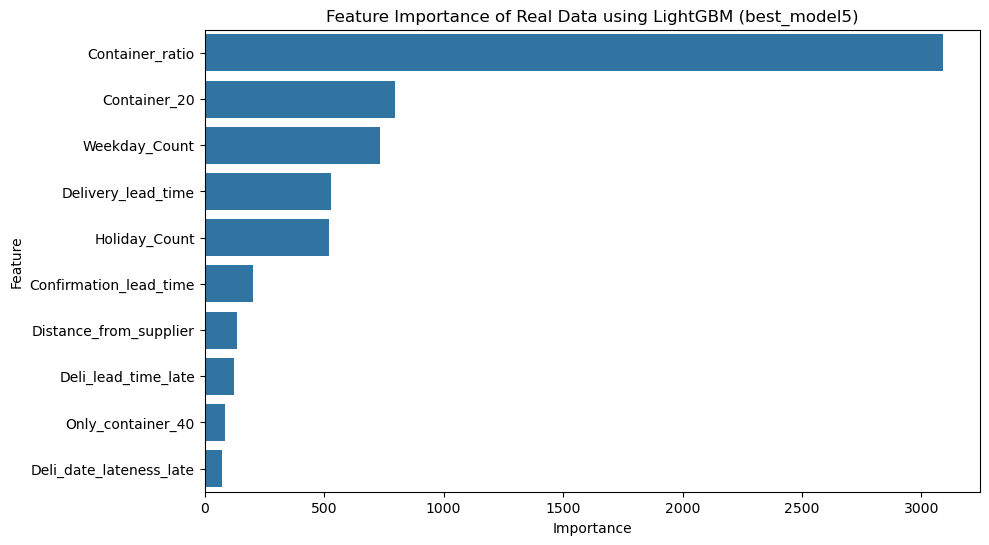

                   Feature  Importance
4          Container_ratio        3089
3             Container_20         798
8            Weekday_Count         734
0       Delivery_lead_time         530
9            Holiday_Count         520
2   Confirmation_lead_time         201
1   Distance_from_supplier         135
7      Deli_lead_time_late         123
5        Only_container_40          86
6  Deli_date_lateness_late          74


In [13]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature names as provided
feature_names = [
    'Delivery_lead_time', 'Distance_from_supplier', 'Confirmation_lead_time', 
    'Container_20', 'Container_ratio', 'Only_container_40', 
    'Deli_date_lateness_late', 'Deli_lead_time_late', 
    'Weekday_Count', 'Holiday_Count'
]

# Assuming x_real_scaled is a NumPy array (scaled real features)
# Convert x_real_scaled to a pandas DataFrame with the provided feature names
X_real_df = pd.DataFrame(X_real_scaled, columns=feature_names)

# Get feature importances from the trained LightGBM model (best_model5)
importances = best_model5.feature_importances_

# Create a DataFrame to display the feature importances along with feature names
feature_importance_df = pd.DataFrame({
    'Feature': X_real_df.columns,  # Using the feature names from the DataFrame
    'Importance': importances
})

# Sort the features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances as a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance of Real Data using LightGBM (best_model5)')
plt.show()

# Optionally, print the sorted importance table
print(feature_importance_df)
